## Value at Risk
- Historic VaR: Uses actual past returns. Sorts them. Takes the 5th percentile. Depends fully on past data
- Parametric (Gaussean) VaR: Assumes returns follow a normal distribution. Uses mean and standard deviation. Applies Z-score formula. Assumes returns are normally distributed. 

In [49]:
import yfinance as yf
import pandas as pd
from pypfopt import EfficientFrontier
from pypfopt import risk_models, expected_returns
import numpy as np
import matplotlib.pyplot as plt

In [7]:
tickers = ['NVDA', 'TSLA', 'JPM', 'XOM', 'NVO']

df = yf.download(tickers, start="2018-01-01")["Close"]
df.head()

[*********************100%***********************]  5 of 5 completed


Ticker,JPM,NVDA,NVO,TSLA,XOM
Date,,,,,
2018-01-02,86.340904,4.928533,23.195585,21.368668,58.970898
2018-01-03,86.428886,5.252898,23.418291,21.150000,60.129089
2018-01-04,87.667007,5.280586,23.336922,20.974667,60.212315
2018-01-05,87.104233,5.325337,23.443989,21.105333,60.163761
2018-01-08,87.232857,5.488512,23.422571,22.427334,60.434235


### Compute returns

In [13]:
returns = df.pct_change().dropna()
returns.head()

Ticker,JPM,NVDA,NVO,TSLA,XOM
Date,,,,,
2018-01-03,0.001019,0.065814,0.009601,-0.010233,0.019640
2018-01-04,0.014325,0.005271,-0.003475,-0.008290,0.001384
2018-01-05,-0.006419,0.008475,0.004588,0.006230,-0.000806
2018-01-08,0.001477,0.030641,-0.000914,0.062638,0.004496
2018-01-09,0.005069,-0.000271,0.003109,-0.008085,-0.004246


### Expected returns and covariance

In [19]:
mu = expected_returns.mean_historical_return(df)
S = risk_models.sample_cov(df)

In [21]:
ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()
clean_weights = ef.clean_weights()
clean_weights

OrderedDict([('JPM', 0.13254),
             ('NVDA', 0.61016),
             ('NVO', 0.0),
             ('TSLA', 0.1214),
             ('XOM', 0.13591)])

### Compute porfolio daily portfolio returns
- what we are doing here is: computing The return of the WHOLE portfolio each day multiplying the returns and its weights

In [32]:
weights_array = np.array(list(clean_weights.values()))

portfolio_returns = returns.dot(weights_array) #each return multiplied by the corresponding weight (w1*R1 + w2*R2... w5*R5)
portfolio_returns

Date
2018-01-03    0.041719
2018-01-04    0.004297
2018-01-05    0.004967
2018-01-08    0.027107
2018-01-09   -0.001052
                ...   
2026-02-05   -0.015084
2026-02-06    0.060272
2026-02-09    0.018917
2026-02-10   -0.003751
2026-02-11    0.006213
Length: 2038, dtype: float64

### Historical 95% VaR
- it sorts the returns and takes the worst 5%
- This shows the actual worst 5% of historical outcomes.

In [62]:
var_95_hist = np.percentile(portfolio_returns, 5) #Give me the value below which 5% of the data falls
var_95_hist
print("Historical VaR:", var_95_hist)
# On 5% of days, the portfolio lost 3.6% or more.

Historical VaR: -0.03661938317032666


### Parametric 95% VaR
- z-score: it indicates exactly how many standard deviations a data point is above (positive Z-score) or below (negative Z-score) the average.
- parametric VaR = VaR= μ+Z⋅σ

In [60]:
mean = portfolio_returns.mean() #The average daily return of your portfolio.
std = portfolio_returns.std() #How much returns fluctuate around the mean.

z = -1.645 #95% of values lie above -1.645 standard deviations and 5% lie below it

var_95_param = mean + z * std
print("Parametric VaR:", var_95_param)

# Only 5% of days are expected to have losses worse than 3.77%

Parametric VaR: -0.037731390775352196


### Plot distribution

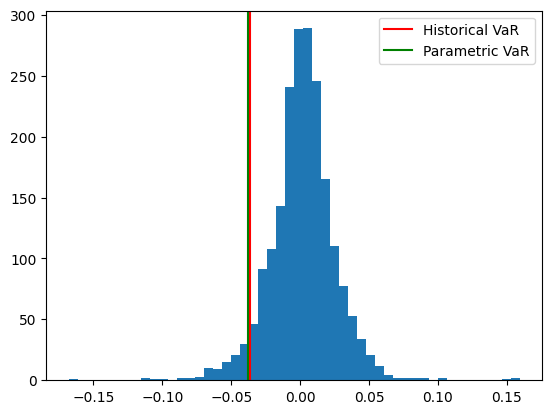

In [51]:
plt.hist(portfolio_returns, bins=50)
plt.axvline(var_95_hist, color='red', label='Historical VaR')
plt.axvline(var_95_param, color='green', label='Parametric VaR')
plt.legend()
plt.show()

### Compute Historical CVaR (Expected Shortfall)
- CVaR (Expected Shortfall) is the average of the worst 5% of returns.
- So we take the numbers that are on the 5% percentile (-0.0366 and less) and average them out to examine how extreme the values are

In [69]:
cvar_95_hist = portfolio_returns[portfolio_returns <= var_95_hist].mean()
print("Historical CVaR:", cvar_95_hist)

# When things are bad (worst 5% of days), the average loss is 5.4%.
# VaR hides how deep the tail is. CVaR reveals it.

Historical CVaR: -0.0543024272115932


### Compute Parametric CVaR (Expected Shortfall)

In [87]:
from scipy.stats import norm

alpha = 0.05
z = -1.645

cvar_95_param = mean - std * (norm.pdf(z) / alpha)
print("Parametric CVaR:", cvar_95_param)

Parametric CVaR: -0.04777784891631355


### Conclusion
- We built an optimized portfolio using the maximum Sharpe ratio approach
- We computed daily portfolio returns using the optimized weights.
- Historical 95% VaR ≈ -3.66%: On 5% of days, the portfolio lost 3.66% or more.
- Parametric 95% VaR ≈ -3.77%: Assuming normal distribution, worst expected daily loss is about 3.77%.
- Both VaR methods produced very similar results. This suggests the portfolio returns are approximately normally distributed.
- Historical 95% CVaR ≈ -5.43%: When the portfolio is in the worst 5% of days, the average loss is about 5.43%, showing that extreme losses are significantly larger than the VaR cutoff.
- Measuring performance (Sharpe), downside threshold risk (VaR), and tail severity (CVaR) provides a more complete view of portfolio risk.